# Factores de riesgo
Este proyecto se corresponde al trabajo final del curso de Data Science dictado por la Fundación YPF en el año 2024.

## Objetivos del notebook 

Realizar un análisis exploratorio sobre los datos obtenidos del INDEC.

## Setup de archivos

__Importación de librerías__

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
import seaborn as sns

from functools import reduce

from utils.funcions import *
from utils.codificaciones import *

__Importación de base de datos__

In [4]:
## Leo el archivo localmente
friesgo_2018 = pd.read_csv('datasets/friesgo2018.txt', delimiter = '|')

In [5]:
## Leo el archivo localmente - CSV exportado de archivo 'acondicionamiento'
friesgo_2018_raw = pd.read_csv('datasets/friesgo_2018.csv')

## Análisis del dataset

In [124]:
# Determinar filas y columnas
friesgo_2018_raw.shape

(29224, 104)

In [125]:
# Obtener las 5 primeras filas del dataset
friesgo_2018_raw.head()

,id,cod_provincia,tamanio_aglomerado,submuestra,sexo,edad,situacion_conyugal,nivel_educ,cobertura_salud,es_fumador,...,consentimiento_bq,medicion_glucosa,medicion_glucosa_no_registrada,glucemia_elevada,prevalencia_glucemia_elevada_combinada,findrisc,medicion_colesterol,medicion_colesterol_no_registrada,colesterol_elevado,prevalencia_colesterol_combinada
0,1128639,2,1,1,1,32,6,7,2,2,...,2.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN
1,1709939,2,1,0,2,65,2,7,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6874130,2,1,0,2,33,6,7,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10319375,2,1,1,2,64,3,7,1,1,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11140857,2,1,0,1,24,6,5,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Filtrado de columnas 

In [126]:
# consumo_alcohol = consumo_alcohol_raw.filter(items=['id','freq_cons_alc','tipo_bebida'])
# colesterol = colesterol_raw.filter(items=['id','medido_colesterol','colesterol_alto','tratamiento_medico_col'])
# alimentacion = alimentacion_raw.filter(items=['id','consumo_sal', 'consumo_semanal_futas', 'ranking_dieta','media_fv_diaria'])
# caract_encuestado = caract_encuestado_raw.filter(items=['id', 'sexo', 'edad','situacion_conyugal', 'nivel_educ', 'cobertura_salud'])
# ubicacion = ubicacion_raw.filter(items=['id', 'cod_provincia', 'tamanio_aglomerado', 'submuestra'])

##  Análisis exploratorio

Se vuelve a agrupar en bloques temáticos para realizar el análisis exploratorio sobre los datos.
Por cada temática, se realizan las siguientes tareas:

* Determinar nulos y su porcentaje proporcional, por columna.
* Procesar datos faltantes, definiendo la estrategia a utilizar.
* Determinar la existencia de outliers, definiendo la estrategia a utilizar.
* Determinar la existencia de colinealidad.
* Calcular nuevas columnas, si es necesario.
* Seleccionar las columnas del bloque temático que son de utilidad para el objetivo.
* Convertir variables categóricas a variables numéricas. 

### Análisis por bloques temáticos

#### Ubicación

Esta seccion detalla la ubicacion geografica del encuestado, su provincia, a que aglomerado pertenecen y si participaron de los pasos 2 y 3 de la encuesta

__Columnas de esta seccion__
+ cod_provincia
+ tamanio_aglomerado
+ submuestra

In [6]:
columnas_ubicacion = ['id', 'cod_provincia', 'region', 'tamanio_aglomerado', 'aglomerado','localidades_150', 'submuestra']
ubicacion_raw = filtrar_columnas(friesgo_2018_raw,columnas_ubicacion) 

In [7]:
# ubico mi dataset con columnas filtradas
ubicacion = ubicacion_raw.filter(items=['id','cod_provincia','tamanio_aglomerado','submuestra'])

Comienzo el AED / EDA

In [8]:
# calculo los nulos presentes en mi tabla
calcular_nulos_y_porcentaje(ubicacion)

,Nulos,Porcentaje
id,0,0.0%
cod_provincia,0,0.0%
tamanio_aglomerado,0,0.0%
submuestra,0,0.0%


In [9]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


A continuacion voy a definir los ejes para poder graficar:
+ Los encuestados por provincia
+ La proporcion de encuestados por paso de la encuesta completado 

In [10]:
# defino ejes
encuestados_por_prov = ubicacion.groupby('cod_provincia')['id'].count()
encuestados_por_prov.index = encuestados_por_prov.index.map(cod_provincia_abrev)
es_submuestra = ubicacion.groupby('submuestra')['id'].count()
es_submuestra.index = ['No','Si']

<Axes: ylabel='¿Ha completado los pasos 2 y 3 de la encuesta?'>

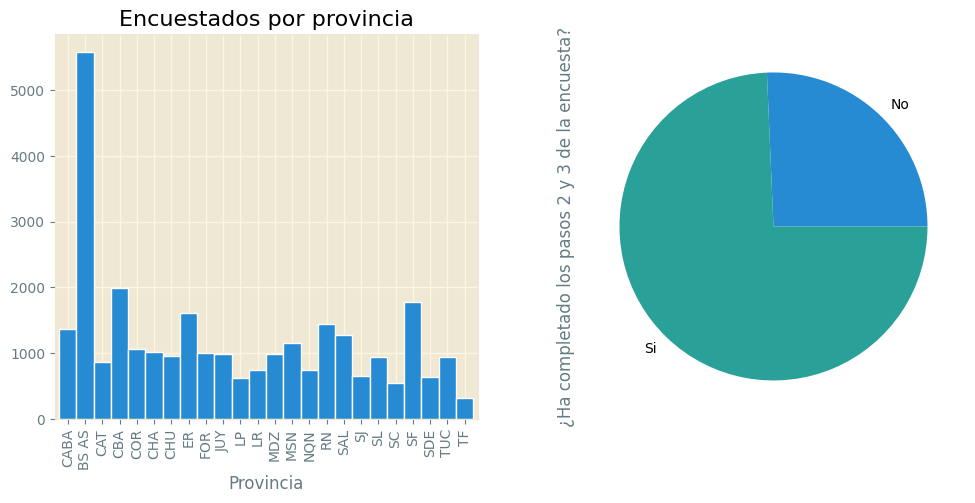

In [11]:
# creo la figura en la que voy a hacer mis graficos
plt.figure(figsize=(12, 5))
plt.style.use('Solarize_Light2')
# primer subplot
plt.subplot(1, 2, 1)
encuestados_por_prov.plot(kind='bar',width=1,edgecolor="white", title='Encuestados por provincia', xlabel='Provincia')
# Segundo subplot
plt.subplot(1, 2, 2)
es_submuestra.plot(kind='pie', ylabel='¿Ha completado los pasos 2 y 3 de la encuesta?')

In [12]:
# describo la composicion de mis datos
ubicacion.describe()

,id,cod_provincia,tamanio_aglomerado,submuestra
count,2.922400e+04,29224.000000,29224.000000,29224.000000
mean,1.075470e+09,38.383931,3.235389,0.743191
std,6.223720e+08,28.722040,1.056942,0.436881
min,1.171400e+04,2.000000,1.000000,0.000000
25%,5.358276e+08,10.000000,3.000000,0.000000
50%,1.079500e+09,34.000000,4.000000,1.000000
75%,1.622154e+09,62.000000,4.000000,1.000000
max,2.147433e+09,94.000000,4.000000,1.000000


En resumen: Esta tabla no tiene valores nulos, en la provincia de Buenos Aires se observan mayor proporcion de encuestados, y al rededor de un 70% de los encuestados completo los pasos 2 y 3 de la encuesta. 
* Los pasos 2 y 3 se refieren a si completaron el cuestionario del indec en las secciones que corresponden a las preguntas sobre bloque individual(situacion laboral, habitos alimenticios, historial medico, etc.) y mediciones bioquimicas y antropometricas.

#### Características del encuestado

Esta seccion detalla caracteristicas que detallan caracteristicas biologicas (edad, sexo) y socioeconomicas (situacion conyugal, nivel educativo) del encuestado 

Esta seccion contiene las siguientes columnas:
+ sexo
+ edad
+ situacion_conyugal
+ nivel_educ
+ cobertura_salud
+ condicion actividad

In [13]:
columnas_caract_encuestado = ['id', 'relacion_jefeh', 'sexo', 'edad', 'rango_etario','situacion_conyugal', 'nivel_educ', 'nivel_eduG', 'obra_social','o_social_prep', 'o_soc_pre_vol', 'sem', 'asoc_prog_salud_estatal','no_asociado_nada', 'nosabe', 'cobertura_salud', 'condicion_actividad']
caract_encuest_raw = filtrar_columnas(friesgo_2018_raw,columnas_caract_encuestado)

In [14]:
caract_encuest = caract_encuest_raw.filter(items=['id', 'sexo', 'edad', 'situacion_conyugal', 'nivel_educ','cobertura_salud','condicion_actividad'])

In [15]:
# calculamos los nulos presentes
calcular_nulos_y_porcentaje(caract_encuest)

,Nulos,Porcentaje
id,0,0.0%
sexo,0,0.0%
edad,0,0.0%
situacion_conyugal,0,0.0%
nivel_educ,0,0.0%
cobertura_salud,0,0.0%
condicion_actividad,0,0.0%


In [16]:
caract_encuest.describe()

,id,sexo,edad,situacion_conyugal,nivel_educ,cobertura_salud,condicion_actividad
count,2.922400e+04,29224.000000,29224.000000,29224.00000,29224.000000,29224.000000,29224.000000
mean,1.075470e+09,1.569121,46.489084,3.38287,4.673727,1.304647,1.744662
std,6.223720e+08,0.495208,18.052815,1.99178,1.605286,0.460266,0.942676
min,1.171400e+04,1.000000,18.000000,1.00000,1.000000,1.000000,1.000000
25%,5.358276e+08,1.000000,32.000000,2.00000,3.000000,1.000000,1.000000
50%,1.079500e+09,2.000000,44.000000,3.00000,5.000000,1.000000,1.000000
75%,1.622154e+09,2.000000,61.000000,6.00000,6.000000,2.000000,3.000000
max,2.147433e+09,2.000000,104.000000,6.00000,8.000000,2.000000,3.000000


In [17]:
# Frecuencia absoluta de mis variables categoricas
sexo_counts = caract_encuest['sexo'].value_counts()
situacion_conyugal_counts = caract_encuest['situacion_conyugal'].value_counts()
nivel_educ_counts = caract_encuest['nivel_educ'].value_counts()
cobertura_salud_counts = caract_encuest['cobertura_salud'].value_counts()
condicion_actividad_counts = caract_encuest['condicion_actividad'].value_counts()


In [18]:
condicion_actividad_counts

condicion_actividad
1    17668
3    10206
2     1350
Name: count, dtype: int64

In [19]:
print(f'Cuentas por categoria:\n Sexo : {sexo_counts} \n Situacion conyugal : {situacion_conyugal_counts} \n Nivel educativo : {nivel_educ_counts} \n Cobertura salud : {cobertura_salud_counts} \n Condicion laboral : {condicion_actividad_counts}')

Cuentas por categoria:
 Sexo : sexo
2    16632
1    12592
Name: count, dtype: int64 
 Situacion conyugal : situacion_conyugal
2    8447
6    8234
1    6142
5    2939
3    2122
4    1340
Name: count, dtype: int64 
 Nivel educativo : nivel_educ
5    7274
3    5496
7    5377
4    4796
6    3601
2    2289
1     344
8      47
Name: count, dtype: int64 
 Cobertura salud : cobertura_salud
1    20321
2     8903
Name: count, dtype: int64 
 Condicion laboral : condicion_actividad
1    17668
3    10206
2     1350
Name: count, dtype: int64


In [20]:
conteo_df = caract_encuest.groupby(['nivel_educ', 'condicion_actividad']).size().unstack(fill_value=0).T
conteo_df

nivel_educ,1,2,3,4,5,6,7,8
condicion_actividad,,,,,,,,
1,98,779,2557,2905,4857,2210,4246,16
2,12,92,222,328,378,203,114,1
3,234,1418,2717,1563,2039,1188,1017,30


Graficos:
- distribucion de edades

In [21]:
x_edades = [10,20,30,40,50,60,70,80,90,100] # esta lista es para nombrar los xticks
# calculo proporciones para el nivel educativo
educ_counts = caract_encuest.groupby('sexo')['nivel_educ'].value_counts(normalize=True).unstack().fillna(0)
educ_labels = educ_counts.columns
# busco las etiquetas de situacion conyugal
situacion_conyugal_counts.index = situacion_conyugal_counts.index.map(situacion_conyugal)


C:\Users\Biank\AppData\Local\Temp\ipykernel_14004\3312717877.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(['Masculino', 'Femenino']) # Cambiar las etiquetas del eje x


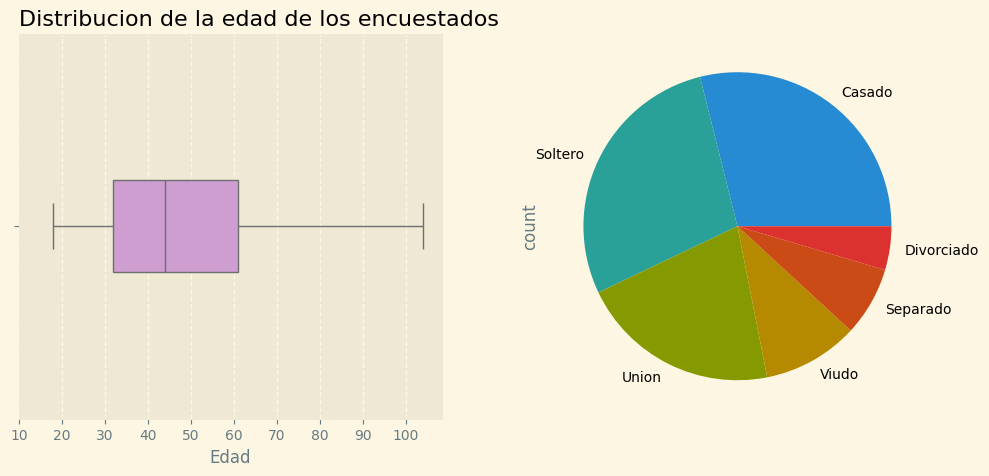

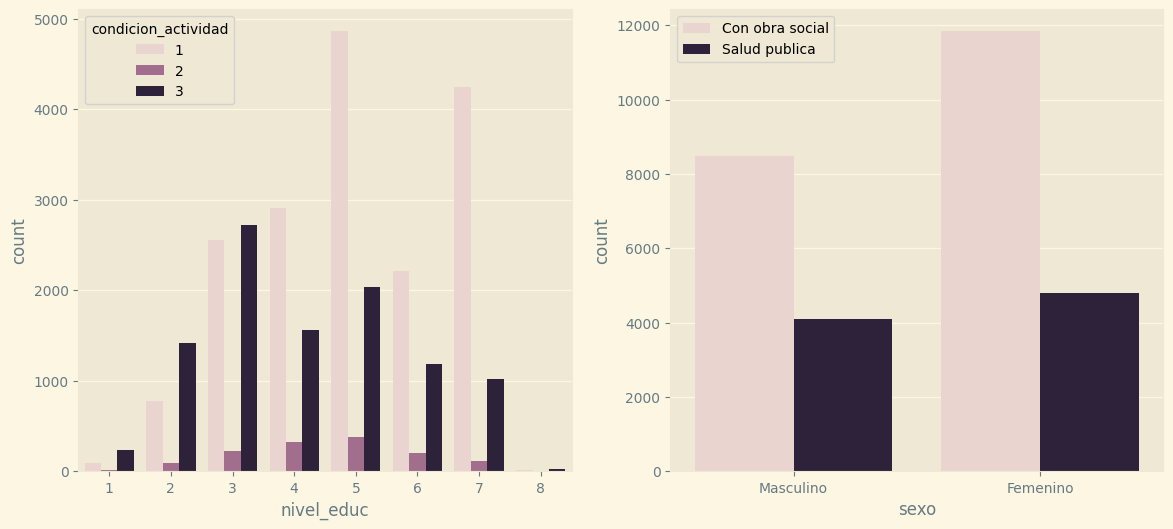

In [22]:
# creo la primera figura en la que voy a hacer mis graficos
plt.figure(figsize=(12, 5))
plt.style.use('Solarize_Light2')
# primer subplot
plt.subplot(1, 2, 1)
sns.boxplot(x=caract_encuest['edad'], gap=0.7, color='#d695d9')
#sns.stripplot(x=caract_encuest['edad'], data=caract_encuest, color='blue', jitter=True, alpha=0.6)
plt.title('Distribucion de la edad de los encuestados', loc='left')
plt.xlabel('Edad')
plt.xticks(ticks=x_edades, labels=x_edades)
plt.grid(True, which='both', axis='x', linestyle='--')
#segundo subplot
plt.subplot(1,2,2)
situacion_conyugal_counts.plot(kind='pie')
# creo la segunda figura
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
# primer subplot
sns.countplot(data=caract_encuest, x="nivel_educ", hue="condicion_actividad", ax=ax[0])
# segundo subplot
sns.countplot(data=caract_encuest, x="sexo", hue="cobertura_salud", ax=ax[1])
ax[1].set_xticklabels(['Masculino', 'Femenino']) # Cambiar las etiquetas del eje x
handles, labels = ax[1].get_legend_handles_labels()
ax[1].legend(handles, ['Con obra social', 'Salud publica']) # Cambiar las etiquetas de la leyenda
plt.show()

In [23]:
print(nivel_educ)
print(condicion_actividad)

{1: 'Sin instrucción', 2: 'Primario incompleto', 3: 'Primario completo', 4: 'Secundario incompleto', 5: 'Secundario completo', 6: 'Terciario/universitario incompleto', 7: 'Terciario/universitario completo', 8: 'Educación especial'}
{1: 'Ocupado', 2: 'Desocupado', 3: 'Inactivo'}


Del analisis de caracteristicas del encuestado podemos decir: 
+ Que la mayoria de los encuestados son mujeres, estan casados, han completado el secundario y cuentan con obra social, prepaga o servicio de emergencia médica.
+ Respecto de las edades, la edad promedio es 46.49 años, las edades minima y maxima son 18 y 104 años, el 25% de los individuos tienen 32 años o menos, el 50% tienen 44 años o menos, y el 75% tienen 61 años o menos. No se observan outliers.
+ Que los individuos cuentan en su mayoria con algun tipo de salud privada, ya se obra social, servicio de emergencia u otros.
+ Se observa a nivel laboral, que aquellos con secundario completo y terciario/universitario completos son aquellos con mayor proporcion de ocupados (osea trabajando activamente). Tambien se observa una poca presencia de individuos clasificados como desocupados(aquellos buscando trabajo activamente/ trabajando de manera informal), en comparacion con los ocupados e inactivos(poblacion no economicamente activa).
(*) Las definiciones a los terminos provienen de documentacion del INDEC : https://www.indec.gob.ar/ftp/cuadros/menusuperior/eph/EPH_Conceptos.pdf

#### Salud general

#### Actividad física

#### Tabaquismo

##### Selección del bloque temático

In [24]:
# Detección de columnas correspondientes a Tabaquismo en el dataframe
indice_inicial = friesgo_2018_raw.columns.get_loc('es_fumador')
indice_final = friesgo_2018_raw.columns.get_loc('cant_tipos_tabaco')

# Selección de la columna 0 - correspondiente a la columna id - y el rango de preguntas para Tabaquismo
tabaquismo_raw = friesgo_2018_raw.iloc[:, [0] + list(range(indice_inicial, indice_final + 1))].copy()

In [25]:
# Visualización de las primeras 20 filas
tabaquismo_raw.head(20)

,id,es_fumador,edad_fuma_primera_vez,edad_fuma_primera_vez_ns_nc,fumado_100_cigarrillos,periodicidad_fumador,es_cigarrillo_armado,es_cigarrillo_paquete,marca_cigarrillos,tipo_paquete_comprado,...,hubo_fumadores_hospital,hubo_fumadores_otros_lugares,publicidad_comercios,publicidad_email,suscripcion_cigarrera,vio_propaganda_riesgo_fumar,propaganda_piensa_dejar_fumar,acuerdo_impuesto_tabaco,condicion_fumador,cant_tipos_tabaco
0,1128639,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98,2,1,2,2,1,NaN,2,3,0
1,1709939,1,20.0,NaN,2.0,3.0,NaN,NaN,NaN,NaN,...,2,2,1,2,2,2,NaN,1,3,0
2,6874130,1,18.0,NaN,1.0,3.0,NaN,NaN,NaN,NaN,...,2,1,1,2,2,1,NaN,2,2,0
3,10319375,1,14.0,NaN,1.0,1.0,2.0,1.0,1.0,1.0,...,1,2,2,2,2,1,2.0,1,1,0
4,11140857,1,13.0,NaN,2.0,3.0,NaN,NaN,NaN,NaN,...,2,2,1,2,2,1,NaN,99,3,0
5,12665714,1,14.0,NaN,1.0,2.0,2.0,1.0,2.0,1.0,...,2,1,1,2,2,1,2.0,2,1,5
6,13089112,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2,1,2,2,2,1,NaN,99,3,0
7,19254804,1,16.0,NaN,2.0,3.0,NaN,NaN,NaN,NaN,...,2,2,1,2,2,2,NaN,1,3,0
8,19959160,1,16.0,NaN,1.0,3.0,NaN,NaN,NaN,NaN,...,2,2,2,2,2,1,NaN,1,2,0
9,21544403,1,18.0,NaN,1.0,3.0,NaN,NaN,NaN,NaN,...,2,2,98,2,2,2,NaN,1,2,0


##### Selección de columnas para EDA

In [26]:
# Selección de columnas
tabaquismo = tabaquismo_raw[[
    'id', 
    'condicion_fumador', 
    'edad_fuma_primera_vez', 
    'fumado_100_cigarrillos',
    'periodicidad_fumador',
    'cant_tipos_tabaco'
]]

# Visualización de las primeras 20 filas
tabaquismo.head(20)

,id,condicion_fumador,edad_fuma_primera_vez,fumado_100_cigarrillos,periodicidad_fumador,cant_tipos_tabaco
0,1128639,3,NaN,NaN,NaN,0
1,1709939,3,20.0,2.0,3.0,0
2,6874130,2,18.0,1.0,3.0,0
3,10319375,1,14.0,1.0,1.0,0
4,11140857,3,13.0,2.0,3.0,0
5,12665714,1,14.0,1.0,2.0,5
6,13089112,3,NaN,NaN,NaN,0
7,19254804,3,16.0,2.0,3.0,0
8,19959160,2,16.0,1.0,3.0,0
9,21544403,2,18.0,1.0,3.0,0


###### __Valores para columna condicion_fumador__

In [27]:
mostrar_valores_columna(tabaquismo, 'condicion_fumador', condicion_fumador)

,Valor,Cantidad,Proporción (%)
0,No fumador,17198,58.85%
1,Fumador actual,6247,21.38%
2,Ex fumador,5779,19.77%


Se detectan 3 categorías `No fumador`, `Fumador actual` y `Ex fumador`, mismas categorías descriptas en la información de la base de datos. Se visualiza la cantidad de muestras por categoría y su proporción respecto al total de valores.

###### __Valores para columna fumado_100_cigarrillos__

In [28]:
mostrar_valores_columna(tabaquismo, 'fumado_100_cigarrillos', fumado_100_cigarrillos)

,Valor,Cantidad,Proporción (%)
0,NaN,14042,48.05%
1,Sí,12026,41.15%
2,No,3026,10.35%
3,Ns/Nc,130,0.44%


Se detectan 4 categorías `NaN`, `Sí`, `No` y `Ns/Nc`, a excepción de `NaN`, son las mismas categorías descriptas en la información de la base de datos. Se visualiza la cantidad de muestras por categoría y su proporción respecto al total de valores.
En el apartado `Evaluación de nulos` se tratará de determinar la razón de los datos faltantes y se evaluará si puede o no imputarsele valores y cuáles serían.

###### __Valores para columna periodicidad_fumador__

In [29]:
mostrar_valores_columna(tabaquismo, 'periodicidad_fumador', periodicidad_fumador)

,Valor,Cantidad,Proporción (%)
0,NaN,14042,48.05%
1,...no fuma?,8576,29.35%
2,...todos los días?,4604,15.75%
3,...algunos días?,2002,6.85%


Se detectan 4 categorías `NaN`, `...no fuma?`, `...todos los días?` y `...algunos días?`, a excepción de `NaN`, son las mismas categorías descriptas en la información de la base de datos. Se visualiza la cantidad de muestras por categoría y su proporción respecto al total de valores.
En el apartado `Evaluación de nulos` se tratará de determinar la razón de los datos faltantes y se evaluará si puede o no imputarsele valores y cuáles serían.

##### Evaluación de nulos

In [30]:
# Visualización de nulos y porcentaje
calcular_nulos_y_porcentaje(tabaquismo)

,Nulos,Porcentaje
id,0,0.0%
condicion_fumador,0,0.0%
edad_fuma_primera_vez,14170,48.49%
fumado_100_cigarrillos,14042,48.05%
periodicidad_fumador,14042,48.05%
cant_tipos_tabaco,0,0.0%


De las columnas seleccionadas, 3 presentan cerca del 48% de nulos: `edad_fuma_primera_vez`, `fumado_100_cigarrillos` y `periodicidad_fumador`. A continuación, se analizan estas columnas en profundidad.

###### __Columna edad_fuma_primera_vez__

__Análisis__

`edad_fuma_primera_vez` es una variable numérica continua que contiene la edad en la que la persona fumó por primera vez. La hipótesis con respecto a los nulos es que la persona no fume, por lo que se evalúan los nulos en esta columna con respecto a la columna `condicion_fumador`.

In [31]:
# Evaluación de proporción de nulos en edad_fuma_primera_vez dependiendo de los valores en condicion_fumador
resultados = []
    
# Obtener valores únicos de la columna condicion_fumador
valores_fumador = tabaquismo['condicion_fumador'].unique()

for valor in valores_fumador:
    # Filtrar el DataFrame por cada valor de condicion_fumador
    df_condicion = tabaquismo[tabaquismo['condicion_fumador'] == valor]
    
    # Contar nulos en la columna de edad_fuma_primera_vez para esta condición
    nulos = df_condicion['edad_fuma_primera_vez'].isnull().sum()

    # Calcular proporción de nulos en edad_fuma_primera_vez por condicion_fumador
    total_condicion = tabaquismo['edad_fuma_primera_vez'].isnull().sum()
    proporciones = (nulos / total_condicion) * 100

    resultados.append({
        'Condicion Fumador': condicion_fumador[valor],
        'Nulos en edad_fuma_primera_vez': nulos,
        'Proporción de nulos (%)': proporciones.round(2).astype(str) + '%'
    })

print(pd.DataFrame(resultados))

  Condicion Fumador  Nulos en edad_fuma_primera_vez Proporción de nulos (%)
0        No fumador                           14085                   99.4%
1        Ex fumador                              47                   0.33%
2    Fumador actual                              38                   0.27%


Mediante el análisis en conjunto entre estas dos variables, se determina que un 99.4% de los valores nulos de la variable `edad_fuma_primera_vez` corresponden a personas que no han fumado nunca, por lo que los valores nulos no son errores.

La columna `edad_fuma_primera_vez` tiene un 0.6% de errores, puesto que tanto para `Ex fumador` como `Fumador actual` la edad en la que fumó por primera debiera ser un valor que exista.


__Estrategia de tratamiento de nulos__

Al detectar que los valores nulos en esta columna no se corresponden a errores, se decide ignorarlos y continuar con el análisis en otras columnas.

###### __Columna fumado_100_cigarrillos__

__Análisis__

`fumado_100_cigarrillos` es una variable categórica con 3 valores posibles: Si, No, Ns/Nc. La hipótesis con respecto a los nulos es que la persona no fume, por lo que se evalúan los nulos en esta columna con respecto a la columna `condicion_fumador`.

In [32]:
# Evaluación de proporción de nulos en edad_fuma_primera_vez dependiendo de los valores en condicion_fumador
resultados = []
    
# Obtener valores únicos de la columna condicion_fumador
valores_fumador = tabaquismo['condicion_fumador'].unique()

for valor in valores_fumador:
    # Filtrar el DataFrame por cada valor de condicion_fumador
    df_condicion = tabaquismo[tabaquismo['condicion_fumador'] == valor]
    
    # Contar nulos en la columna de edad_fuma_primera_vez para esta condición
    nulos = df_condicion['fumado_100_cigarrillos'].isnull().sum()

    # Calcular proporción de nulos en edad_fuma_primera_vez por condicion_fumador
    total_condicion = tabaquismo['fumado_100_cigarrillos'].isnull().sum()
    proporciones = (nulos / total_condicion) * 100

    resultados.append({
        'Condicion Fumador': condicion_fumador[valor],
        'Nulos en fumado_100_cigarrillos': nulos,
        'Proporción de nulos (%)': proporciones.round(2).astype(str) + '%'
    })

print(pd.DataFrame(resultados))

  Condicion Fumador  Nulos en fumado_100_cigarrillos Proporción de nulos (%)
0        No fumador                            14042                  100.0%
1        Ex fumador                                0                    0.0%
2    Fumador actual                                0                    0.0%


Mediante el análisis en conjunto entre estas dos variables, se determina que todos los valores nulos de la variable `fumado_100_cigarrillos` corresponden a personas que no han fumado nunca, por lo que los valores nulos no son errores.


__Estrategia de tratamiento de nulos__

Para salvar los campos nulos en esta columna, se le imputa el valor `2` que corresponde a la respuesta `No`.

In [33]:
# Reemplazo de valores NaN por 2 (opcion No)
tabaquismo.loc[:, 'fumado_100_cigarrillos'] = tabaquismo['fumado_100_cigarrillos'].fillna(2)

# Verifico que ya no existen valores NaN en la columna fumado_100_cigarrillos
mostrar_valores_columna(tabaquismo, 'fumado_100_cigarrillos', fumado_100_cigarrillos)

,Valor,Cantidad,Proporción (%)
0,No,17068,58.4%
1,Sí,12026,41.15%
2,Ns/Nc,130,0.44%


###### __Columna periodicidad_fumador__

__Análisis__

`periodicidad_fumador` es una variable categórica que indica cuanto fuma una persona. La hipótesis con respecto a los nulos es que la persona no fume, por lo que evaluaremos el nulo en esta columna con respecto a la columna `condicion_fumador`.

In [34]:
# Evaluación de proporción de nulos en edad_fuma_primera_vez dependiendo de los valores en condicion_fumador
resultados = []
    
# Obtener valores únicos de la columna condicion_fumador
valores_fumador = tabaquismo['condicion_fumador'].unique()

for valor in valores_fumador:
    # Filtrar el DataFrame por cada valor de condicion_fumador
    df_condicion = tabaquismo[tabaquismo['condicion_fumador'] == valor]
    
    # Contar nulos en la columna de edad_fuma_primera_vez para esta condición
    nulos = df_condicion['periodicidad_fumador'].isnull().sum()

    # Calcular proporción de nulos en edad_fuma_primera_vez por condicion_fumador
    total_condicion = tabaquismo['periodicidad_fumador'].isnull().sum()
    proporciones = (nulos / total_condicion) * 100

    resultados.append({
        'Condicion Fumador': condicion_fumador[valor],
        'Nulos en periodicidad_fumador': nulos,
        'Proporción de nulos (%)': proporciones.round(2).astype(str) + '%'
    })

print(pd.DataFrame(resultados))



  Condicion Fumador  Nulos en periodicidad_fumador Proporción de nulos (%)
0        No fumador                          14042                  100.0%
1        Ex fumador                              0                    0.0%
2    Fumador actual                              0                    0.0%


Mediante el análisis en conjunto entre estas dos variables, se determina que todos los valores nulos de la variable `periodicidad_fumador` corresponden a personas que no han fumado nunca, por lo que los valores nulos no son errores.


__Estrategia de tratamiento de nulos__

Para salvar los campos nulos en esta columna, se les imputa el valor `3` que corresponde a la respuesta `...no fuma`.

In [35]:
# Reemplazo de valores NaN por 2 (opcion No)
tabaquismo.loc[:, 'periodicidad_fumador'] = tabaquismo['periodicidad_fumador'].fillna(3)

# Verifico que ya no existen valores NaN en la columna fumado_100_cigarrillos
mostrar_valores_columna(tabaquismo, 'periodicidad_fumador', periodicidad_fumador)

,Valor,Cantidad,Proporción (%)
0,...no fuma?,22618,77.4%
1,...todos los días?,4604,15.75%
2,...algunos días?,2002,6.85%


##### Evaluación de outliers

Se evalúan outliers sobre la columna `edad_fuma_primera_vez` por ser la única variable numérica continua de este bloque temático. Utilizaremos el RIC para determinar outliers.

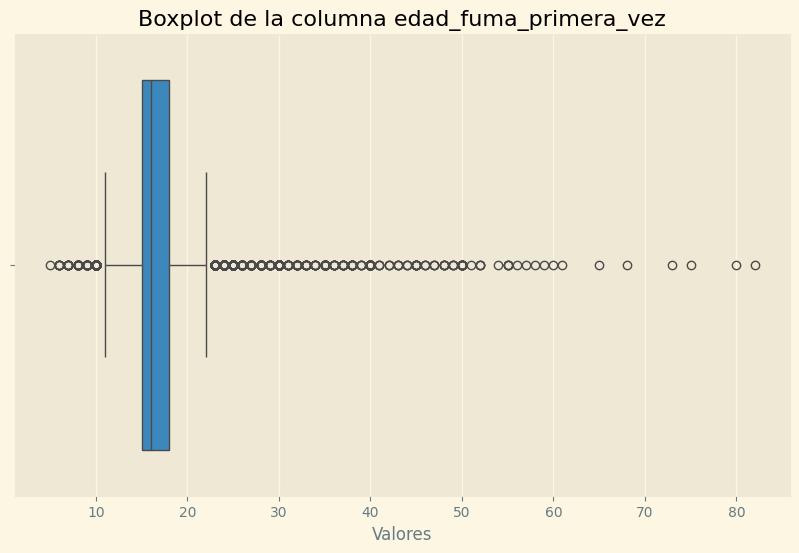

Outliers: id                        1.670673e+12
condicion_fumador         2.919000e+03
edad_fuma_primera_vez     4.086800e+04
fumado_100_cigarrillos    3.799000e+03
periodicidad_fumador      3.516000e+03
cant_tipos_tabaco         7.900000e+01
dtype: float64


In [36]:
q1 = tabaquismo['edad_fuma_primera_vez'].quantile(0.25)
q3 = tabaquismo['edad_fuma_primera_vez'].quantile(0.75)

iqr = q3 - q1
lb = q1 - (iqr * 1.5)
ub = q3 + (iqr * 1.5)

# Dibujar el boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=tabaquismo['edad_fuma_primera_vez'])
plt.title('Boxplot de la columna edad_fuma_primera_vez')
plt.xlabel('Valores')
plt.show()

# Outliers
outliers = (tabaquismo[(tabaquismo['edad_fuma_primera_vez'] < lb) | (tabaquismo['edad_fuma_primera_vez'] > ub)]).sum()
print("Outliers:", outliers)

Esta variable tiene una gran cantidad de outliers, por lo que se tratará de determinar posibles errores en la carga de la variable. Para esto, se analizará la columna `edad`, del bloque temático `caract_encuest`.

In [37]:
# Union de dataframes por la columna 'id', utilizando 'inner join' como metodo de union
dfs = [
    caract_encuest[['id', 'edad']],
    tabaquismo
]
tb_aux = reduce(lambda left, right: pd.merge(left, right, on='id', how='inner'), dfs)

tb_aux.head(5)

,id,edad,condicion_fumador,edad_fuma_primera_vez,fumado_100_cigarrillos,periodicidad_fumador,cant_tipos_tabaco
0,1128639,32,3,NaN,2.0,3.0,0
1,1709939,65,3,20.0,2.0,3.0,0
2,6874130,33,2,18.0,1.0,3.0,0
3,10319375,64,1,14.0,1.0,1.0,0
4,11140857,24,3,13.0,2.0,3.0,0


Filtrado de filas para las que se cumplan las siguientes condiciones:
- La persona es `Fumador` o `Ex Fumador` (valores 1 o 2) en la columna `condicion_fumador`.
- La `edad_fuma_primera_vez` de la persona es mayor a la `edad` de la persona

Las filas que cumplan estas condiciones representan filas con errores.

In [38]:
filas_invalidas = (
    tb_aux[(
            (tb_aux['condicion_fumador'] == 1) | 
            (tb_aux['condicion_fumador'] == 2)
            ) & 
           (tb_aux['edad_fuma_primera_vez'] > tb_aux['edad'])])

# Mostrar las filas identificadas
print(filas_invalidas)

Empty DataFrame
Columns: [id, edad, condicion_fumador, edad_fuma_primera_vez, fumado_100_cigarrillos, periodicidad_fumador, cant_tipos_tabaco]
Index: []


No se observan errores en la carga, por lo que se pueden corregir valores outliers.
No se realizarán acciones de limpieza de outliers por el momento, se evaluará posteriormente la necesidad de hacerlo.

##### Evaluación de colinealidad

##### Conversión de variables categóricas a numéricas

Las variables categóricas del bloque temático ya están representadas como variables numéricas, por lo que no es necesario realizar este paso.

#### Hipertensión

#### Peso corporal

#### Alimentación

Se detallan aqui los habitos alimenticios tales como el consumo de sal o frutas y verduras del encuestado

Esta seccion contiene las siguientes columnas:
+ consumo_sal
+ consumo_semanal_futas
+ ranking_dieta
+ media_fv_diaria

In [39]:
alimentacion_columnas = ['id', 'sal1', 'sal2', 'consumo_semanal_frutas', 'consumo_semanal_nsnc','porciones_diarias_frutas', 'porcionesf_diarias_nsnc','consumo_semanal_verduras', 'consumo_semanal_v_nsnc','porciones_diarias_verduras', 'porcionesv_diarias_nsnc','razon_bajo_consumo', 'ranking_dieta', 'razon_dieta_pobre','opinion_impuesto_beb_azucaradas', 'media_fv_diaria', 'consumo_fv','barreras_fyv']
alimentacion_raw = filtrar_columnas(friesgo_2018_raw,alimentacion_columnas)

In [40]:
alimentacion = alimentacion_raw.filter(items=['id', 'consumo_sal', 'consumo_semanal_frutas', 'ranking_dieta','media_fv_diaria'])

##### Nulos

In [41]:
calcular_nulos_y_porcentaje(alimentacion)

,Nulos,Porcentaje
id,0,0.0%
consumo_semanal_frutas,571,1.95%
ranking_dieta,0,0.0%
media_fv_diaria,753,2.58%


Se observan nulos en la culumna 'media_fv_diaria' y en consumo_semanal_frutas, a continuacion tratare de explicar el origen de los mismos.

In [42]:
# Busco que valores tiene la columna submuestra para los valores nulos en la columna consumo_semanal_frutas
valores_nulos_origen1 = friesgo_2018_raw[friesgo_2018_raw['consumo_semanal_frutas'].isna()][['id', 'submuestra']]
valores_nulos_origen1.groupby(friesgo_2018_raw['submuestra']).count()


,id,submuestra
submuestra,,
0,127,127
1,444,444


consumo_semanal_frutas : Esta columna contiene valores enteros correspondientes al nº de frutas consumido, es 0 si no consume frutas, (esto se sabe leyendo la encuesta donde detalla como completarla). De los valores nulos solo 127 de los 571 (22%) no participaron de la encuesta en pasos 2 y 3, viendo como debe completarse la encuesta no hay indicio de que estos valores nan pertenezcan a una respuesta negativa a una pregunta anterior, por lo que se asume estos valores de nan son por inconsistencias o fallos durante la traslacion de datos o su rellenado.

In [43]:
# la columna media_fv_diaria depende de las respuestas a las consumo_semanal_futas y consumo_semanal_verduras
valores_nulos_origen3 = friesgo_2018_raw[friesgo_2018_raw['media_fv_diaria'].isna()][['id', 'submuestra']]
valores_nulos_origen3.groupby(friesgo_2018_raw['submuestra']).count()

,id,submuestra
submuestra,,
0,161,161
1,592,592


In [44]:
# Agregar columnas consumo_semanal_frutas y consumo_semanal_verduras para análisis
valores_nulos_detallados = friesgo_2018_raw[friesgo_2018_raw['media_fv_diaria'].isna()][['id', 'submuestra', 'consumo_semanal_frutas', 'consumo_semanal_verduras']]
valores_nulos_detallados.head()

,id,submuestra,consumo_semanal_frutas,consumo_semanal_verduras
187,299017967,1,7.0,NaN
356,543490565,1,NaN,5.0
423,641196897,1,NaN,2.0
471,715256952,0,NaN,5.0
473,716369786,1,NaN,NaN


In [45]:
valores_nulos_detallados_submuestra_1 = friesgo_2018_raw[(friesgo_2018_raw['media_fv_diaria'].isna()) & (friesgo_2018_raw['submuestra'] == 1)][['id', 'submuestra', 'consumo_semanal_frutas', 'consumo_semanal_verduras']]
valores_nulos_detallados_submuestra_1.isna().count()

id                          592
submuestra                  592
consumo_semanal_frutas      592
consumo_semanal_verduras    592
dtype: int64

In [46]:
# Filtrar registros donde media_fv_diaria es NaN, submuestra es igual a 1, y ambos consumo_semanal_frutas y consumo_semanal_verduras no son NaN
valores_nulos_detallados_condicion = friesgo_2018_raw[(friesgo_2018_raw['media_fv_diaria'].isna()) & (friesgo_2018_raw['submuestra'] == 1) &(friesgo_2018_raw['consumo_semanal_frutas'].notna()) & (friesgo_2018_raw['consumo_semanal_verduras'].notna())][['id', 'submuestra', 'consumo_semanal_frutas', 'consumo_semanal_verduras']]
valores_nulos_detallados_condicion.shape

(22, 4)

__media_fv_diaria__: De los 753 valores faltantes, 161 (21%) es porque los encuestados no completaron los pasos 2 y 3, 592 (78.6%) son porque uno de las dos columnas de las que dependen consumo semanal frutas/verduras es nan, y por ultimo 22 (2%) no encuentro razon, por lo que es probable sean datos mal ingresados.

##### EDA y graficos

In [47]:
alimentacion.describe()

,id,consumo_semanal_frutas,ranking_dieta,media_fv_diaria
count,2.922400e+04,28653.000000,29224.000000,28471.000000
mean,1.075470e+09,4.062576,2.376027,2.071157
std,6.223720e+08,2.503138,5.076342,1.708309
min,1.171400e+04,0.000000,1.000000,0.000000
25%,5.358276e+08,2.000000,2.000000,1.000000
50%,1.079500e+09,4.000000,2.000000,1.640000
75%,1.622154e+09,7.000000,3.000000,2.710000
max,2.147433e+09,7.000000,99.000000,18.000000


#### Colesterol

Detalla si el encuestado fue diagnosticado por profesional con alto colesterol y si esta en tratamiento

Esta seccion contiene las siguientes columnas:
+ medido_colesterol
+ colesterol_alto
+ tratamiento_medico_col

In [48]:
colesterol_columnas = ['id', 'medido_colesterol', 'fecha_med_colesterol', 'colesterol_alto','tratamiento_medico_col', 'trat_habitos_col', 'trat_farmac_col','autocontrol_col', 'prevalencia_colesterol']
colesterol_raw = filtrar_columnas(friesgo_2018_raw,colesterol_columnas)

In [49]:
colesterol = colesterol_raw.filter(items=['id', 'medido_colesterol', 'colesterol_alto', 'tratamiento_medico_col'])

##### Nulos

In [50]:
# Calculo nulos y porcentaje
calcular_nulos_y_porcentaje(colesterol)

,Nulos,Porcentaje
id,0,0.0%
medido_colesterol,0,0.0%
colesterol_alto,0,0.0%
tratamiento_medico_col,22841,78.16%


In [51]:
# creo una tabla sin filtrar
columnas_colesterol = ['id', 'medido_colesterol', 'fecha_med_colesterol', 'colesterol_alto','tratamiento_medico_col', 'trat_habitos_col', 'trat_farmac_col','autocontrol_col', 'prevalencia_colesterol']
colesterol_nofiltro = filtrar_columnas(friesgo_2018_raw,columnas_colesterol)

In [52]:
colesterol_raw.sample(5)

,id,medido_colesterol,fecha_med_colesterol,colesterol_alto,tratamiento_medico_col,trat_habitos_col,trat_farmac_col,autocontrol_col,prevalencia_colesterol
3870,186922322,1,3.0,1,2.0,NaN,NaN,1.0,1.0
5888,1499205535,1,1.0,2,NaN,NaN,NaN,NaN,2.0
13219,722721495,1,1.0,1,2.0,NaN,NaN,1.0,1.0
9978,1422591873,1,1.0,2,NaN,NaN,NaN,1.0,2.0
16148,1023145195,1,2.0,1,2.0,NaN,NaN,NaN,1.0


Se observan nulos en tratamiento_medico_col a continuacion explicaremos el origen, esta columna depende de las respuestas en medido_colesterol y colesterol_alto

In [53]:
valores_nulos_origen4 = friesgo_2018_raw[friesgo_2018_raw['tratamiento_medico_col'].isna()][['id', 'medido_colesterol','colesterol_alto']]
valores_nulos_origen4.groupby([friesgo_2018_raw['medido_colesterol'], friesgo_2018_raw['colesterol_alto']]).count()

id  medido_colesterol  colesterol_alto
medido_colesterol colesterol_alto                                           
1                 2                14150              14150            14150
                  99                 137                137              137
2                 2                 8024               8024             8024
                  99                 160                160              160
99                2                  248                248              248
                  99                 122                122              122

Del total de nulos (22841) un 62% (14150) se deben a individuos que se han medido el colesterol pero la medicion fue baja; un 6% (137) se han medido el colesterol pero no saben/ no contestan si tienen alto el colesterol; un 35% no se ha medido el colesterol y no han sido diagnosticados con colesterol alto; un 7% no se ha medido y no sabe/contesta si lo han diagnosticado con colesterol alto; por ultimo un 1,6% no sabe/contesta si alguna vez se ha medido el colesterol.

##### EDA y graficos

In [54]:
colesterol.describe()

,id,medido_colesterol,colesterol_alto,tratamiento_medico_col
count,2.922400e+04,29224.000000,29224.000000,6383.000000
mean,1.075470e+09,2.543936,3.172324,1.528435
std,6.223720e+08,11.021336,11.565054,0.499230
min,1.171400e+04,1.000000,1.000000,1.000000
25%,5.358276e+08,1.000000,2.000000,1.000000
50%,1.079500e+09,1.000000,2.000000,2.000000
75%,1.622154e+09,2.000000,2.000000,2.000000
max,2.147433e+09,99.000000,99.000000,2.000000


#### Consumo de alcohol

Esta seccion detalla la frecuencia de consumo de alcohol y los tipos consumidos

Esta seccion contiene las siguientes columnas:
+ freq_cons_alc
+ tipo_bebida

In [55]:
columnas_alcohol = ['id', 'ha_consumido_alc', 'fecha_ult_cons', 'freq_30_ds', 'freq_30_dm',
       'freq_30_nsnc', 'tragos_cerveza', 'tragos_cerveza_notoma',
       'tragos_vino', 'tragos_vino_notoma', 'tragos_bebida_fuerte',
       'tragos_bebida_fuerte_notoma', 'toma_otras_bebidas',
       'sobrecon_cant_cerveza', 'sobrecon_cerv_notoma', 'sobrecon_cant_vino',
       'sobrecon_vino_notoma', 'sobrecon_cant_bebfuerte',
       'sobrecon_bebfuerte_notoma', 'sobrecon_otrasb', 'manejo_alcholizado30',
       'aprueba_aumento_imp_alchol', 'consumo_regular_riesgo',
       'consumo_mensual','consumo_vino', 'consumo_cerveza',
       'consumo_bebidas_fuertes', 'tipo_bebida','freq_cons_alc']
consumo_alcohol_raw = filtrar_columnas(friesgo_2018_raw,columnas_alcohol)

In [56]:
consumo_alcohol = consumo_alcohol_raw.filter(items=['id', 'freq_cons_alc', 'tipo_bebida'])

##### Nulos

In [57]:
# calculo los nulos
calcular_nulos_y_porcentaje(consumo_alcohol)

,Nulos,Porcentaje
id,0,0.0%
freq_cons_alc,0,0.0%
tipo_bebida,15148,51.83%


En la columna tipo_bebida, que es una columna creada a partir de otras, se observan nulos, en una proporcion del 51%, esta columna depende de las respuestas a las columnas ha_consumido_alc, fecha_ult_cons y consumo mensual. A continuacion se tratara de llegar al origen de estos valores nulos.

In [58]:
# quienes responden 2: no a ha_consumido_alc tendran en sus registros en la columna tipo_bebida valores nulos, los contaremos
nulos_por_nobeber =  consumo_alcohol_raw[consumo_alcohol_raw['tipo_bebida'].isna()][['id','ha_consumido_alc','fecha_ult_cons','consumo_mensual','consumo_vino','consumo_cerveza','consumo_bebidas_fuertes']]
print(nulos_por_nobeber.groupby(['ha_consumido_alc'])['id'].count().T)
print(nulos_por_nobeber.groupby(['fecha_ult_cons'])['id'].count().T)

ha_consumido_alc
1.0    8953
2.0    6159
Name: id, dtype: int64
fecha_ult_cons
2.0    5619
3.0    3233
Name: id, dtype: int64


In [59]:
calcular_nulos_y_porcentaje(consumo_alcohol_raw[['ha_consumido_alc','fecha_ult_cons','tragos_vino','tragos_cerveza','tragos_bebida_fuerte','toma_otras_bebidas','consumo_mensual','tipo_bebida']])

,Nulos,Porcentaje
ha_consumido_alc,36,0.12%
fecha_ult_cons,6296,21.54%
tragos_vino,23260,79.59%
tragos_cerveza,20595,70.47%
tragos_bebida_fuerte,26947,92.21%
toma_otras_bebidas,15149,51.84%
consumo_mensual,15302,52.36%
tipo_bebida,15148,51.83%


__tipo_bebida__: De los nulos totales 15148, un 40% (6159) se deben a que los individuos no toman alcohol; un 37% (5619) se debe a que la persona bebio pero hace mas de un mes, por lo que no califica para la pregunta tipo_bebida (segun protocolo encuesta INDEC); otro 21%(3233) igualmente bebio hace mas de un año, por lo que no califica a la pregunta. Un 1% que es el restante puede deberse a errores durante la creacion de la bd.

##### EDA y graficos

In [60]:
consumo_alcohol.describe()

,id,freq_cons_alc,tipo_bebida
count,2.922400e+04,29224.000000,14076.000000
mean,1.075470e+09,335.880235,2.356564
std,6.223720e+08,158.893224,1.412791
min,1.171400e+04,100.000000,1.000000
25%,5.358276e+08,200.000000,1.000000
50%,1.079500e+09,300.000000,2.000000
75%,1.622154e+09,500.000000,3.000000
max,2.147433e+09,500.000000,5.000000


#### Diabetes

##### Selección del bloque temático

In [61]:
# Detección de columnas correspondientes a Diabetes en el dataframe
indice_inicial = friesgo_2018_raw.columns.get_loc('es_diabetico')
indice_final = friesgo_2018_raw.columns.get_loc('diagnostico_cosanguineos')

# Selección de la columna 0 - correspondiente a la columna id - y el rango de preguntas para Tabaquismo
diabetes_raw = friesgo_2018_raw.iloc[:, [0] + list(range(indice_inicial, indice_final + 1))].copy()

In [62]:
# Visualización de las primeras 20 filas
diabetes_raw.head(20)

,id,es_diabetico,es_diabetes_gestacional,en_tratamiento_diabetes,en_tratamiento_diabetes_insulina,en_tratamiento_diabetes_otros,en_tratamiento_diabetes_medicamentos,es_insulinodependiente,diagnostico_diabetes_cosanguineo_primario,diagnostico_diabetes_cosanguineo_secundario,ultima_medicion_glucemia,controla_diabetes,lugar_control_diabetes,atencion_diabetes_mismo_profesional,atencion_diabetes_hc,revision_pies,revision_pupilas,educado_control_diabetes,control_diabetes,diagnostico_cosanguineos
0,1128639,2,NaN,NaN,NaN,NaN,NaN,NaN,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,sin_antecedentes
1,1709939,2,NaN,NaN,NaN,NaN,NaN,NaN,2,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,sin_antecedentes
2,6874130,2,NaN,NaN,NaN,NaN,NaN,NaN,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,sin_antecedentes
3,10319375,2,NaN,NaN,NaN,NaN,NaN,NaN,2,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,secundario
4,11140857,2,NaN,NaN,NaN,NaN,NaN,NaN,2,99,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,sin_antecedentes
5,12665714,2,NaN,NaN,NaN,NaN,NaN,NaN,2,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,sin_antecedentes
6,13089112,99,NaN,NaN,NaN,NaN,NaN,NaN,2,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,sin_antecedentes
7,19254804,2,NaN,NaN,NaN,NaN,NaN,NaN,2,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,sin_antecedentes
8,19959160,2,NaN,NaN,NaN,NaN,NaN,NaN,2,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,secundario
9,21544403,2,NaN,NaN,NaN,NaN,NaN,NaN,2,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,sin_antecedentes


##### Selección de columnas para EDA

In [63]:
# Selección de columnas
diabetes = diabetes_raw[[
    'id', 
    'es_diabetico', 
    'es_diabetes_gestacional', 
    'en_tratamiento_diabetes',
    'diagnostico_cosanguineos',
    'ultima_medicion_glucemia'
]]

# Visualización de las primeras 20 filas
diabetes.head(5)

,id,es_diabetico,es_diabetes_gestacional,en_tratamiento_diabetes,diagnostico_cosanguineos,ultima_medicion_glucemia
0,1128639,2,NaN,NaN,sin_antecedentes,2
1,1709939,2,NaN,NaN,sin_antecedentes,1
2,6874130,2,NaN,NaN,sin_antecedentes,2
3,10319375,2,NaN,NaN,secundario,2
4,11140857,2,NaN,NaN,sin_antecedentes,1


###### __Valores para columna es_diabetico__

In [64]:
mostrar_valores_columna(diabetes, 'es_diabetico', es_diabetico)

,Valor,Cantidad,Proporción (%)
0,No,25165,86.11%
1,Si,3924,13.43%
2,Ns/Nc,135,0.46%


Se detectan 3 categorías `No`, `Si` y `Ns/Nc`, mismas categorías descriptas en la información de la base de datos. Se visualiza la cantidad de muestras por categoría y su proporción respecto al total de valores.

###### __Valores para columna es_diabetes_gestacional__

In [65]:
mostrar_valores_columna(diabetes, 'es_diabetes_gestacional', es_diabetes_gestacional)

,Valor,Cantidad,Proporción (%)
0,NaN,26829,91.8%
1,No,1835,6.28%
2,Si,537,1.84%
3,Ns/Nc,23,0.08%


Se detectan 4 categorías `NaN`, `Sí`, `No` y `Ns/Nc`, a excepción de `NaN`, son las mismas categorías descriptas en la información de la base de datos. Se visualiza la cantidad de muestras por categoría y su proporción respecto al total de valores.
En el apartado `Evaluación de nulos` se tratará de determinar la razón de los datos faltantes y se evaluará si puede o no imputarsele valores y cuáles serían.

###### __Valores para columna en_tratamiento_diabetes__

In [66]:
mostrar_valores_columna(diabetes, 'en_tratamiento_diabetes', en_tratamiento_diabetes)

,Valor,Cantidad,Proporción (%)
0,NaN,25300,86.57%
1,Si,2166,7.41%
2,No,1758,6.02%


Se detectan 3 categorías `NaN`, `Sí` y `No`, a excepción de `NaN`, son las mismas categorías descriptas en la información de la base de datos. Se visualiza la cantidad de muestras por categoría y su proporción respecto al total de valores.
En el apartado `Evaluación de nulos` se tratará de determinar la razón de los datos faltantes y se evaluará si puede o no imputarsele valores y cuáles serían.

###### __Valores para columna diagnostico_cosanguineos__

In [67]:
mostrar_valores_columna(diabetes, 'diagnostico_cosanguineos')

,Valor,Cantidad,Proporción (%)
0,sin_antecedentes,13983,47.85%
1,primario,9619,32.91%
2,secundario,4904,16.78%
3,ns_nc,718,2.46%


Se detectan 4 categorías `sin_antecedentes`, `cosanguineo_primario`, `cosanguineo_secundario` y `ns_nc`, calculadas a partir de otras columnas en el archivo acondicionamieto. Se visualiza la cantidad de muestras por categoría y su proporción respecto al total de valores.
En el apartado `Conversión de variables categóricas a numéricas` se realizará la transformación correspondiente de los valores.

###### __Valores para columna ultima_medicion_glucemia__

In [68]:
mostrar_valores_columna(diabetes, 'ultima_medicion_glucemia', ultima_medicion_glucemia)

,Valor,Cantidad,Proporción (%)
0,Menos de 1 año,15476,52.96%
1,Nunca se la midió,5471,18.72%
2,De 1 a 2 años,4014,13.74%
3,Más de 2 años,3313,11.34%
4,Ns/nc,950,3.25%


Se detectan 5 categorías `Menos de 1 año`, `Nunca se la midió`, `De 1 a 2 años`, `Más de 2 años` y `Ns/nc`, mismas descriptas en la información de la base de datos. Se visualiza la cantidad de muestras por categoría y su proporción respecto al total de valores.

##### Evaluación de nulos

In [69]:
# Visualización de nulos y porcentaje
calcular_nulos_y_porcentaje(diabetes)

,Nulos,Porcentaje
id,0,0.0%
es_diabetico,0,0.0%
es_diabetes_gestacional,26829,91.8%
en_tratamiento_diabetes,25300,86.57%
diagnostico_cosanguineos,0,0.0%
ultima_medicion_glucemia,0,0.0%


De las columnas seleccionadas, 2 presentan alrededor de 90% de nulos: `es_diabetes_gestacional` y `en_tratamiento_diabetes`. A continuación, se analizan estas columnas en profundidad.

###### __Columna es_diabetes_gestacional__

__Análisis__

`es_diabetes_gestacional` es una variable categórica que informa si la persona presenta diabetes debido a un embarazo. La hipótesis con respecto a los nulos es que la persona no sea diabética, por lo que se evalúan los nulos en esta columna con respecto a la columna `es_diabetico`.

In [70]:
# Evaluación de proporción de nulos en es_diabetes_gestacional dependiendo de los valores en es_diabetico
resultados = []
    
# Obtener valores únicos de la columna es_diabetico
valores_fumador = diabetes['es_diabetico'].unique()

for valor in valores_fumador:
    # Filtrar el DataFrame por cada valor de es_diabetico
    df_condicion = diabetes[diabetes['es_diabetico'] == valor]
    
    # Contar nulos en la columna de es_diabetes_gestacional para esta condición
    nulos = df_condicion['es_diabetes_gestacional'].isnull().sum()

    # Calcular proporción de nulos en es_diabetes_gestacional por es_diabetico
    total_condicion = diabetes['es_diabetes_gestacional'].isnull().sum()
    proporciones = (nulos / total_condicion) * 100

    resultados.append({
        'Es diabético': es_diabetico[valor],
        'Nulos en es_diabetes_gestacional': nulos,
        'Proporción de nulos (%)': proporciones.round(2).astype(str) + '%'
    })

print(pd.DataFrame(resultados))

  Es diabético  Nulos en es_diabetes_gestacional Proporción de nulos (%)
0           No                             25165                   93.8%
1        Ns/Nc                               135                    0.5%
2           Si                              1529                    5.7%


Mediante el análisis en conjunto entre estas dos variables, se determina que un 93.8% de los valores nulos de la variable `es_diabetes_gestacional` corresponden a personas que no son diabéticas, por lo que los valores nulos no son errores.

También se observan NaN para las respuestas `Si` y `Ns/Nc` en `es_diabetico` pero se necesita evaluar el sexo de la persona para determinar si es un error:
1. Si es hombre -> Es diabético -> NaN en es_diabetes_gestacional -> OK
2. Si es mujer  -> Es diabética -> NaN en es_diabetes_gestacional -> Imposible determinar si existe error por no contar con datos de embarazo en la base de datos


###### __Columna en_tratamiento_diabetes__

__Análisis__

`en_tratamiento_diabetes` es una variable categórica que informa si la persona se encuentra en tratamiento por diabetes. La hipótesis con respecto a los nulos es que la persona no sea diabética, por lo que se evalúan los nulos en esta columna con respecto a la columna `es_diabetico`.

In [71]:
# Evaluación de proporción de nulos en en_tratamiento_diabetes dependiendo de los valores en es_diabetico
resultados = []
    
# Obtener valores únicos de la columna es_diabetico
valores_fumador = diabetes['es_diabetico'].unique()

for valor in valores_fumador:
    # Filtrar el DataFrame por cada valor de es_diabetico
    df_condicion = diabetes[diabetes['es_diabetico'] == valor]
    
    # Contar nulos en la columna de en_tratamiento_diabetes para esta condición
    nulos = df_condicion['en_tratamiento_diabetes'].isnull().sum()

    # Calcular proporción de nulos en en_tratamiento_diabetes por es_diabetico
    total_condicion = diabetes['en_tratamiento_diabetes'].isnull().sum()
    proporciones = (nulos / total_condicion) * 100

    resultados.append({
        'Es diabético': es_diabetico[valor],
        'Nulos en en_tratamiento_diabetes': nulos,
        'Proporción de nulos (%)': proporciones.round(2).astype(str) + '%'
    })

print(pd.DataFrame(resultados))

  Es diabético  Nulos en en_tratamiento_diabetes Proporción de nulos (%)
0           No                             25165                  99.47%
1        Ns/Nc                               135                   0.53%
2           Si                                 0                    0.0%


Mediante el análisis en conjunto entre estas dos variables, se determina que un 99.47% de los valores nulos de la variable `en_tratamiento_diabetes` corresponden a personas que no son diabéticas, por lo que los valores nulos no son errores.

La columna `en_tratamiento_diabetes` tiene un 0.53% de nulos para las respuestas `Ns/Nc` en `es_diabetico`, esto puede responderse porque la columna incluye información sobre métodos cotidianos de cuidados, tales como ejercicio o dieta. Al ser un porcentaje tan bajo, no se realizará ninguna imputación.


##### Evaluación de outliers

Este bloque no contiene variables numéricas continuas que requieran un análisis de outliers.

##### Evaluación de colinealidad

##### Conversión de variables categóricas a numéricas

La única variable categórica del bloque temático que necesita una transformación es `diagnostico_cosanguineos`.

In [72]:
# Convertir variables categóricas en variables dummy
diabetes = pd.get_dummies(diabetes, columns=['diagnostico_cosanguineos'])

# Visualización del dataset final
diabetes.head(5)

,id,es_diabetico,es_diabetes_gestacional,en_tratamiento_diabetes,ultima_medicion_glucemia,diagnostico_cosanguineos_ns_nc,diagnostico_cosanguineos_primario,diagnostico_cosanguineos_secundario,diagnostico_cosanguineos_sin_antecedentes
0,1128639,2,NaN,NaN,2,False,False,False,True
1,1709939,2,NaN,NaN,1,False,False,False,True
2,6874130,2,NaN,NaN,2,False,False,False,True
3,10319375,2,NaN,NaN,2,False,False,True,False
4,11140857,2,NaN,NaN,1,False,False,False,True


#### Mediciones antropométricas

In [73]:
# Detección de columnas correspondientes a Mediciones antropométricas en el dataframe
indice_inicial = friesgo_2018_raw.columns.get_loc('consentimiento_ma')
indice_final = friesgo_2018_raw.columns.get_loc('tipo_medicion_cintura')

# Selección de la columna 0 - correspondiente a la columna id - y el rango de preguntas para Tabaquismo
mediciones_antropometricas_raw = friesgo_2018_raw.iloc[:, [0] + list(range(indice_inicial, indice_final + 1))].copy()

In [74]:
# Visualización de las primeras 5 filas
mediciones_antropometricas_raw.head(5)

,id,consentimiento_ma,bebio_cafeina,consentimiento_presion,primera_medicion_sistolica,primera_medicion_diastolica,segunda_medicion_sistolica,segunda_medicion_diastolica,tercera_medicion_sistolica,tercera_medicion_diastolica,...,prevalencia_hipertension_combinada,consentimiento_altura,medicion_altura,consentimiento_peso,medicion_peso,imc_y,imc_categoria,consentimiento_cintura,medicion_cintura,tipo_medicion_cintura
0,1128639,1.0,2.0,1.0,151.0,99.0,147.0,100.0,148.0,97.0,...,1.0,1.0,181.0,1.0,106.0,32.36,3.0,1.0,103.0,2.0
1,1709939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6874130,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10319375,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11140857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Selección de columnas para EDA

In [75]:
# Selección de columnas
mediciones_antropometricas = mediciones_antropometricas_raw[[
    'id', 
    'bebio_cafeina', 
    'presion_arterial_elevada', 
    'imc_categoria'
]]

# Visualización de las primeras 5 filas
mediciones_antropometricas.head(5)

,id,bebio_cafeina,presion_arterial_elevada,imc_categoria
0,1128639,2.0,1.0,3.0
1,1709939,NaN,NaN,NaN
2,6874130,NaN,NaN,NaN
3,10319375,NaN,NaN,NaN
4,11140857,NaN,NaN,NaN


###### __Valores para columna bebio_cafeina__

In [76]:
mostrar_valores_columna(mediciones_antropometricas, 'bebio_cafeina', bebio_cafeina)

,Valor,Cantidad,Proporción (%)
0,No,16394,56.1%
1,NaN,12647,43.28%
2,Si,183,0.63%


Se detectan 3 categorías `No`, `Sí` y `NaN`, con 2 categorías descriptas en la información de la base de datos pero con nulos. Se visualiza la cantidad de muestras por categoría y su proporción respecto al total de valores. En el apartado `Evaluación de nulos` se tratará de determinar la razón de los datos faltantes y se evaluará si puede o no imputarsele valores y cuáles serían.

###### __Valores para columna presion_arterial_elevada__

In [77]:
mostrar_valores_columna(mediciones_antropometricas, 'presion_arterial_elevada', presion_arterial_elevada)

,Valor,Cantidad,Proporción (%)
0,NaN,12997,44.47%
1,No elevada,9743,33.34%
2,Elevada,6484,22.19%


Se detectan 3 categorías `Elevada`, `No elevada` y `NaN`, con 2 categorías descriptas en la información de la base de datos pero con nulos. Se visualiza la cantidad de muestras por categoría y su proporción respecto al total de valores. En el apartado `Evaluación de nulos` se tratará de determinar la razón de los datos faltantes y se evaluará si puede o no imputarsele valores y cuáles serían.

###### __Valores para columna imc_categoria__

In [78]:
mostrar_valores_columna(mediciones_antropometricas, 'imc_categoria', imc_categoria)

,Valor,Cantidad,Proporción (%)
0,NaN,12647,43.28%
1,Medio,5682,19.44%
2,Alto,5460,18.68%
3,Bajo,5268,18.03%
4,Ns/Nc,167,0.57%


Se detectan 5 categorías `Bajo`, `Medio`, `Alto`, `Ns/Nc` y `NaN`, con 4 categorías descriptas en la información de la base de datos pero con nulos. Se visualiza la cantidad de muestras por categoría y su proporción respecto al total de valores. En el apartado `Evaluación de nulos` se tratará de determinar la razón de los datos faltantes y se evaluará si puede o no imputarsele valores y cuáles serían.

##### Evaluación de nulos

In [79]:
# Visualización de nulos y porcentaje
calcular_nulos_y_porcentaje(mediciones_antropometricas)

,Nulos,Porcentaje
id,0,0.0%
bebio_cafeina,12647,43.28%
presion_arterial_elevada,12997,44.47%
imc_categoria,12647,43.28%


Todas las columnas seleccionadas presentan más del 40% de nulos: `bebio_cafeina`, `presion_arterial_elevada` y `imc_categoria`. A continuación, se analizan estas columnas en profundidad.

###### __Columna bebio_cafeina__

__Análisis__

`bebio_cafeina` es una variable categórica que indica si la persona bebió cafeína en el día de la encuesta. La hipótesis con respecto a los nulos es que la persona no haya dado el consentimiento para realizarse estas mediciones, por lo que analizaremos la columna `consentimiento_ma` en conjunto con esta columna.

In [80]:
# Union de dataframes por la columna 'id', utilizando 'inner join' como metodo de union
dfs = [
    mediciones_antropometricas_raw[['id', 'consentimiento_ma']],
    mediciones_antropometricas
]
ma_aux = reduce(lambda left, right: pd.merge(left, right, on='id', how='inner'), dfs)

ma_aux.head(5)

,id,consentimiento_ma,bebio_cafeina,presion_arterial_elevada,imc_categoria
0,1128639,1.0,2.0,1.0,3.0
1,1709939,NaN,NaN,NaN,NaN
2,6874130,NaN,NaN,NaN,NaN
3,10319375,2.0,NaN,NaN,NaN
4,11140857,NaN,NaN,NaN,NaN


Al analizar el dataframe incluyendo la columna `consentimiento_ma` se ve que existen valores NaN en esta columna y se necesita determinar el origen. La hipótesis de estos nulos es que la respuesta sea `No`, y para determinar si esto es así, se evaluará los valores del resto de las columnas (a excepción de la columna id) buscando que todos sean tambien NaN.

In [81]:
# Crear una columna que indique si todas las columnas son NaN
ma_aux['resto_nan'] = ma_aux[['bebio_cafeina', 'presion_arterial_elevada', 'imc_categoria']].isnull().all(axis=1)

# Comparar resto_nan con los valores NaN en consentimiento_ma
ma_aux['fila_nan'] = ma_aux['consentimiento_ma'].isnull() & ma_aux['resto_nan']

# Determinar la cantidad y porcentaje de True y False para la columna fila_nan
mostrar_valores_columna(ma_aux, 'fila_nan')

,Valor,Cantidad,Proporción (%)
0,False,21719,74.32%
1,True,7505,25.68%


Al evaluar los nulos por fila, se observa que el 74% de las columnas contienen algun valor distinto de NaN, mientras que el 26% contienen todos valores NaN en la fila. Por lo tanto, se imputará `No` a aquellas filas donde todos los valores son NaN (fila_nan == True) y `Sí` a aquellas donde existe al menos un valor distinto de NaN (fila_nan == False).

In [82]:
# Funcion para reemplazar valores en consentimiento_ma
# Si fila_nan == False -> consentimiento_ma == 1
# Si fila_nan == True -> consentimiento_ma == 2
def imputar_consentimiento_ma(row):
    if pd.isna(row['consentimiento_ma']):
        if row['fila_nan']:
            return 2
        else:
            return 1
    else:
        return row['consentimiento_ma']

# Aplicar la función al DataFrame
ma_aux['consentimiento_ma'] = ma_aux.apply(imputar_consentimiento_ma, axis=1)

# Se verifica que ya no existen valores NaN en la columna consentimiento_ma
mostrar_valores_columna(ma_aux, 'consentimiento_ma', consentimiento_ma)

,Valor,Cantidad,Proporción (%)
0,Si,16577,56.72%
1,No,12647,43.28%


Habiendo imputado todos los valores correspondientes en `consentimiento_ma` se puede continuar con la evaluación de nulos en `bebio_cafeina`, con la hipótesis que la respuesta a `consentimiento_ma` es `No`

In [83]:
# Evaluación de proporción de nulos en bebio_cafeina dependiendo de los valores en consentimiento_ma
resultados = []

# Obtener valores únicos de la columna consentimiento_ma
valores_consentimiento = ma_aux['consentimiento_ma'].unique()

for valor in valores_consentimiento:
    # Filtrar el DataFrame por cada valor de consentimiento_ma
    df_condicion = ma_aux[ma_aux['consentimiento_ma'] == valor]
    
    # Contar nulos en la columna de bebio_cafeina para esta condición
    nulos = df_condicion['bebio_cafeina'].isnull().sum()

    # Calcular proporción de nulos en bebio_cafeina por consentimiento_ma
    total_condicion = ma_aux['bebio_cafeina'].isnull().sum()
    proporciones = (nulos / total_condicion) * 100

    resultados.append({
        'Consentimiento': consentimiento_ma[valor],
        'Nulos en bebio_cafeina': nulos,
        'Proporción de nulos (%)': proporciones.round(2).astype(str) + '%'
    })

print(pd.DataFrame(resultados))

  Consentimiento  Nulos en bebio_cafeina Proporción de nulos (%)
0             Si                       0                    0.0%
1             No                   12647                  100.0%


Mediante el análisis en conjunto entre estas dos variables, se determina que todos los valores nulos de la variable `bebio_cafeina` corresponden a personas que no dieron consentimiento para realizar las mediciones, por lo que los valores nulos no son errores.


###### __Columna presion_arterial_elevada__

###### __Columna imc_categoria__

__Análisis__

`imc_categoria` es una variable categórica que indica el índice de masa corporal y es calculada mediante la evaluacion de las columnas `medicion_altura` y `medicion_peso` con las siguientes reglas:

    * Bajo (<25)
    * Medio( >=25 y <30)
    * Alto ( >=30)
    * Ns/Nc

La hipótesis con respecto a los nulos es que la persona no haya dado su consentimiento para realizar las mediciones en general o especificamente para medirse la altura y/o el peso.

In [84]:
# Union de dataframes por la columna 'id', utilizando 'inner join' como metodo de union
dfs = [
    ma_aux,
    mediciones_antropometricas_raw[['id', 'consentimiento_altura', 'consentimiento_peso']]
]
ma_aux = reduce(lambda left, right: pd.merge(left, right, on='id', how='inner'), dfs)

ma_aux.head(5)

,id,consentimiento_ma,bebio_cafeina,presion_arterial_elevada,imc_categoria,resto_nan,fila_nan,consentimiento_altura,consentimiento_peso
0,1128639,1.0,2.0,1.0,3.0,False,False,1.0,1.0
1,1709939,2.0,NaN,NaN,NaN,True,True,NaN,NaN
2,6874130,2.0,NaN,NaN,NaN,True,True,NaN,NaN
3,10319375,2.0,NaN,NaN,NaN,True,False,NaN,NaN
4,11140857,2.0,NaN,NaN,NaN,True,True,NaN,NaN


Al analizar el dataframe incluyendo las columnas `consentimiento_altura` y `consentimiento_peso` se ve que existen valores NaN en estas columnas y se necesita determinar el origen. La hipótesis de estos nulos es que la respuesta sea `No`, y para determinar si esto es así, se evaluará los valores del resto de las columnas de medidas de peso y altura buscando que todos sean tambien NaN.

In [85]:
# Union de dataframes por la columna 'id', utilizando 'inner join' como metodo de union
dfs = [
    ma_aux,
    mediciones_antropometricas_raw[['id', 'medicion_altura', 'medicion_peso']]    
]
ma_aux = reduce(lambda left, right: pd.merge(left, right, on='id', how='inner'), dfs)

ma_aux.head(5)

,id,consentimiento_ma,bebio_cafeina,presion_arterial_elevada,imc_categoria,resto_nan,fila_nan,consentimiento_altura,consentimiento_peso,medicion_altura,medicion_peso
0,1128639,1.0,2.0,1.0,3.0,False,False,1.0,1.0,181.0,106.0
1,1709939,2.0,NaN,NaN,NaN,True,True,NaN,NaN,NaN,NaN
2,6874130,2.0,NaN,NaN,NaN,True,True,NaN,NaN,NaN,NaN
3,10319375,2.0,NaN,NaN,NaN,True,False,NaN,NaN,NaN,NaN
4,11140857,2.0,NaN,NaN,NaN,True,True,NaN,NaN,NaN,NaN


In [86]:
# Determinar valores NaN en consentimiento_altura y medicion_altura
ma_aux['altura_fila_nan'] = ma_aux['consentimiento_altura'].isnull() & ma_aux['medicion_altura'].isnull()

# Determinar la cantidad y porcentaje de True y False para la columna altura_fila_nan
mostrar_valores_columna(ma_aux, 'altura_fila_nan')

,Valor,Cantidad,Proporción (%)
0,False,16577,56.72%
1,True,12647,43.28%


In [87]:
# Determinar valores NaN en consentimiento_peso y medicion_peso
ma_aux['peso_fila_nan'] = ma_aux['consentimiento_peso'].isnull() & ma_aux['medicion_peso'].isnull()

# Determinar la cantidad y porcentaje de True y False para la columna peso_fila_nan
mostrar_valores_columna(ma_aux, 'peso_fila_nan')

,Valor,Cantidad,Proporción (%)
0,False,16577,56.72%
1,True,12647,43.28%


Al evaluar los nulos por fila, tanto para altura como para peso, se observa que el 43% de las columnas contienen todos valores NaN en la fila, misma proporción original. Por lo tanto, al no tener valores posibles para salvar los NaN, no se realizarán imputaciones.

##### Evaluación de outliers

Este bloque no contiene variables numéricas continuas que requieran un análisis de outliers.

##### Evaluación de colinealidad

##### Conversión de variables categóricas a numéricas

Las variables categóricas del bloque temático ya están representadas como variables numéricas, por lo que no es necesario realizar este paso.

#### Mediciones bioquímicas

##### Selección del bloque temático

In [88]:
# Detección de columnas correspondientes a Mediciones bioquímicas en el dataframe
indice_inicial = friesgo_2018_raw.columns.get_loc('consentimiento_bq')
indice_final = friesgo_2018_raw.columns.get_loc('prevalencia_colesterol_combinada')

# Selección de la columna 0 - correspondiente a la columna id - y el rango de preguntas para Tabaquismo
mediciones_bioquimicas_raw = friesgo_2018_raw.iloc[:, [0] + list(range(indice_inicial, indice_final + 1))].copy()

In [89]:
# Visualización de las primeras 20 filas
mediciones_bioquimicas_raw.head(20)

,id,consentimiento_bq,medicion_glucosa,medicion_glucosa_no_registrada,glucemia_elevada,prevalencia_glucemia_elevada_combinada,findrisc,medicion_colesterol,medicion_colesterol_no_registrada,colesterol_elevado,prevalencia_colesterol_combinada
0,1128639,2.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN
1,1709939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6874130,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10319375,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11140857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,12665714,1.0,89.0,NaN,2.0,2.0,NaN,NaN,98.0,NaN,NaN
6,13089112,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,19254804,2.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
8,19959160,1.0,84.0,NaN,2.0,2.0,2.0,152.0,NaN,2.0,2.0
9,21544403,1.0,72.0,NaN,2.0,2.0,NaN,171.0,NaN,2.0,2.0


##### Selección de columnas para EDA

In [90]:
# Selección de columnas
mediciones_bioquimicas = mediciones_bioquimicas_raw[[
    'id', 
    'glucemia_elevada', 
    'colesterol_elevado'
]]

# Visualización de las primeras 5 filas
mediciones_bioquimicas.head(5)

,id,glucemia_elevada,colesterol_elevado
0,1128639,NaN,NaN
1,1709939,NaN,NaN
2,6874130,NaN,NaN
3,10319375,NaN,NaN
4,11140857,NaN,NaN


###### __Valores para columna glucemia_elevada__

In [91]:
mostrar_valores_columna(mediciones_bioquimicas, 'glucemia_elevada', glucemia_elevada)

,Valor,Cantidad,Proporción (%)
0,NaN,24036,82.25%
1,No elevada,4712,16.12%
2,Elevada,476,1.63%


Se detectan 3 categorías `NaN`, `No elevada` y `Elevada`, a excepción de `NaN`, son las mismas categorías descriptas en la información de la base de datos. Se visualiza la cantidad de muestras por categoría y su proporción respecto al total de valores.
En el apartado `Evaluación de nulos` se tratará de determinar la razón de los datos faltantes y se evaluará si puede o no imputarsele valores y cuáles serían.

###### __Valores para colesterol_elevado__

In [92]:
mostrar_valores_columna(mediciones_bioquimicas, 'colesterol_elevado', colesterol_elevado)

,Valor,Cantidad,Proporción (%)
0,NaN,24313,83.2%
1,No elevado,3462,11.85%
2,Elevado,1449,4.96%


Se detectan 3 categorías `NaN`, `No elevado` y `Elevado`, a excepción de `NaN`, son las mismas categorías descriptas en la información de la base de datos. Se visualiza la cantidad de muestras por categoría y su proporción respecto al total de valores.
En el apartado `Evaluación de nulos` se tratará de determinar la razón de los datos faltantes y se evaluará si puede o no imputarsele valores y cuáles serían.

##### Evaluación de nulos

In [93]:
# Visualización de nulos y porcentaje
calcular_nulos_y_porcentaje(mediciones_bioquimicas)

,Nulos,Porcentaje
id,0,0.0%
glucemia_elevada,24036,82.25%
colesterol_elevado,24313,83.2%


Ambas columnas seleccionadas presentan más del 82% de nulos. A continuación, se analizan estas columnas en profundidad.

###### __Columna glucemia_elevada__

__Análisis__

`glucemia_elevada` es una variable categórica que contiene indica si las mediciones de glucemia están dentro de los marcos de referencia. La hipótesis con respecto a los nulos es que la persona haya dado su consentimiento para realizarse mediciones bioquímicas.

In [94]:
# Visualización de columnas de mediciones_bioquimicas
mediciones_bioquimicas_raw.head(5)

,id,consentimiento_bq,medicion_glucosa,medicion_glucosa_no_registrada,glucemia_elevada,prevalencia_glucemia_elevada_combinada,findrisc,medicion_colesterol,medicion_colesterol_no_registrada,colesterol_elevado,prevalencia_colesterol_combinada
0,1128639,2.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN
1,1709939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6874130,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10319375,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11140857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Al analizar el dataframe se ve que existen valores NaN en la columna `consentimiento_bq` y se necesita determinar el origen. La hipótesis de estos nulos es que la respuesta sea `No`, y para determinar si esto es así, se evaluará los valores del resto de las columnas de medidas de `medicion_glucosa` y  `medicion_glucosa_no_registrada` buscando que todos sean tambien NaN.

In [95]:
# Determinar valores NaN en columnas de mediciones de glucosa y colesterol
bq_aux = pd.DataFrame()
bq_aux['bq_fila_nan'] = (
    mediciones_bioquimicas_raw['medicion_glucosa'].isnull() & 
    mediciones_bioquimicas_raw['medicion_glucosa_no_registrada'].isnull() &
    mediciones_bioquimicas_raw['medicion_colesterol'].isnull() & 
    mediciones_bioquimicas_raw['medicion_colesterol_no_registrada'].isnull()
)

# Determinar la cantidad y porcentaje de True y False para la columna bq_fila_nan
mostrar_valores_columna(bq_aux, 'bq_fila_nan')

,Valor,Cantidad,Proporción (%)
0,True,23893,81.76%
1,False,5331,18.24%


Al evaluar los nulos por fila, se observa que casi el 82% de las columnas contienen valores NaN, mientras que sólo el 18% tienen valores válidos en la fila. No se realizarán imputaciones por ser un alto porcentaje de valores faltantes.

### Análisis del dataset en conjunto

In [96]:
# Lista de los dataframes a unir
dfs = [
    ubicacion,
    caract_encuest,
    tabaquismo,
    diabetes,
    alimentacion,
    colesterol,
    consumo_alcohol,
    mediciones_antropometricas
]

# Union de dataframes por la columna 'id', utilizando 'inner join' como metodo de union
friesgo_2018_final = reduce(lambda left, right: pd.merge(left, right, on='id', how='inner'), dfs)

# Verificamos que el dataframe resultante contenga la misma cantidad de filas que el dataframe original
print(friesgo_2018_raw.shape)
print(friesgo_2018_final.shape)

(29224, 216)
(29224, 34)


In [97]:
friesgo_2018_final.to_csv('datasets/friesgo_2018_final.csv', index=False)

EXPLICACION DEL ANALISIS (RELACIONADO AL IMC)

Teniendo en cuenta el objetivo de nuestro proyecto: ___Desarrollar un modelo predictivo para identificar individuos con alto riesgo de desarrollar enfermedades crónicas (como hipertensión, diabetes, colesterol alto) basándose en sus comportamientos y condiciones de vida.___

Primeramente se pretendia utilizar las columnas correspondientes a las tablas mediciones antropometricas y bioquimicas, que contenian columnas indicando parametros como presion arterial elevada, medicion colesterol, medicion de glucemia, etc. las cuales servirian de etiqueta para decir si una persona encuestada tenia una determinada enfermedad cronica; Al realizar un analisis exploratorio en dichas columnas y observar una notable cantidad de valores nulos, decidimos reducir las variables objetivos a solo una la categoria del IMC, por tener mayor cantidad de valores y alinearse de cierto modo con el objetivo inicial del proyecto. 
El nuevo objetivo del proyecto seria: __Predecir si una persona tendra un IMC anormal o no, en base a sus habitos y/o condiciones socioeconomicas__

(**)Nota: Un imc normal seria aquel que entra dentro de los parametros 18.5 y 24.9, segun la OMS, aquellos parametros por encima o debajo de este rango son considerados anormales.


SELECCION DE COLUMNAS FINAL

In [ ]:
# veo el tipo de variable que contiene mi bd final, de manera 'manual' ya que los registros se encuentran codificados
friesgo_2018_final.media_fv_diaria.head()

In [ ]:
# Variables a utilizar para futuro modelado VERIFICAR NOMBRES 
variables_para_modelado = ['cod_provincia','tamanio_aglomerado','sexo','edad','condicion_actividad','ansiedad_depresion'
                           ,'nivel_actividad_fisica','condicion_fumador','prevalencia_hipertension','imc','consumo_sal'
                           ,'media_fv_diarias','colesterol_elevado','freq_cons_alc','es_diabetico','imc_2']

In [ ]:
variables_categoricas = ['cod_provincia','tamanio_aglomerado','sexo','condicion_actividad','ansiedad_depresion'
                           ,'nivel_actividad_fisica','condicion_fumador','prevalencia_hipertension','consumo_sal'
                           ,'colesterol_elevado','freq_cons_alc','es_diabetico']
variables_numericas = ['edad','media_fv_diarias','imc_2']

CREACION DE NUEVA COLUMNA IMC

ELIMINAR FILAS QUE NO TENGAN IMC

#### Análisis de correlacion

In [ ]:
# Creo una tabla de contingencia de mis variables categoricas utilizando pandas.crosstab


#### Preguntas disparadoras

__Pregunta disparadora 1__

* A qué edad comienzan a fumar los hombres y mujeres del país?
* Hay diferencia en la edad dependiendo del sexo?
* Existe alguna diferencia dependiendo del lugar en el que viven?

**Análisis**

Se utiliza el dataset final filtrado anteriormente, `friesgo_2018_final`.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


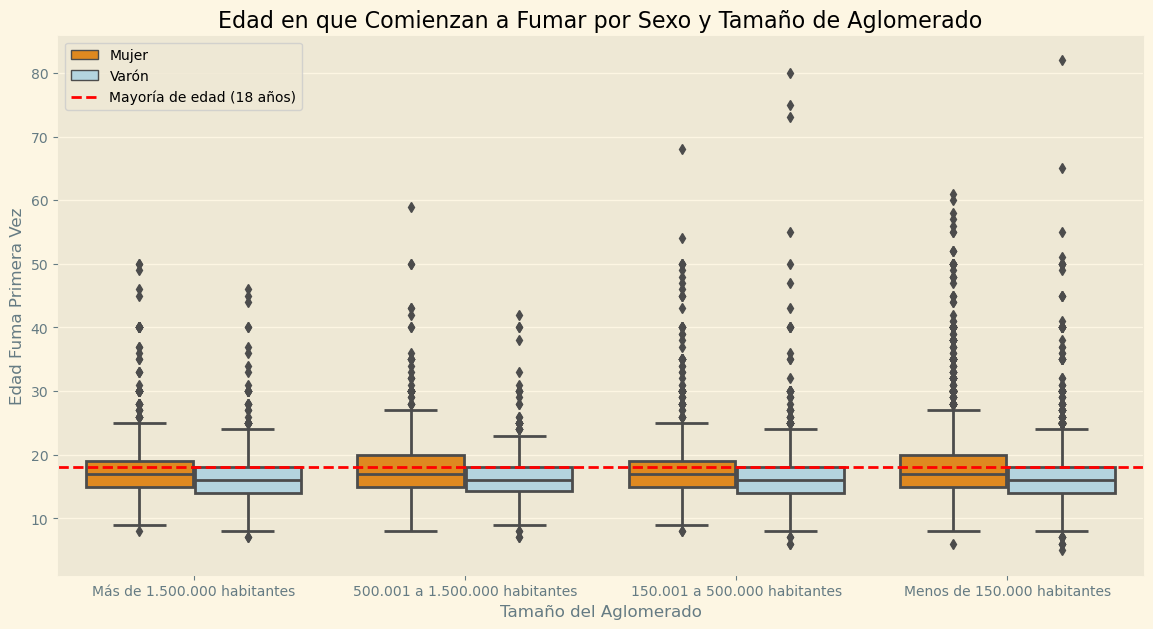

In [ ]:
# Eliminar filas con NaN en las columnas relevantes
preg_disparadora_1 = friesgo_2018_final[['tamanio_aglomerado', 'sexo', 'edad_fuma_primera_vez']].dropna()

# Reemplazar valores por su descripción
preg_disparadora_1['tamanio_aglomerado_desc'] = preg_disparadora_1['tamanio_aglomerado'].map(tamanio_aglomerado)
preg_disparadora_1['sexo'] = preg_disparadora_1['sexo'].map(sexo)

# Definir el orden de tamanio_aglomerado
orden_tamanio_aglomerado = ['Más de 1.500.000 habitantes', '500.001 a 1.500.000 habitantes', '150.001 a 500.000 habitantes', 'Menos de 150.000 habitantes']
preg_disparadora_1['tamanio_aglomerado_desc'] = pd.Categorical(preg_disparadora_1['tamanio_aglomerado_desc'], categories=orden_tamanio_aglomerado, ordered=True)

# Crear el gráfico de cajas
plt.figure(figsize=(14, 7))
paleta = {'Varón': 'lightblue', 'Mujer': 'darkorange'}
sns.boxplot(x='tamanio_aglomerado_desc', y='edad_fuma_primera_vez', hue='sexo', data=preg_disparadora_1, palette=paleta)

# Añadir una línea horizontal en la mayoría de edad (18 años)
plt.axhline(y=18, color='red', linestyle='--', linewidth=2, label='Mayoría de edad (18 años)')

# Añadir título y etiquetas
plt.title('Edad en que Comienzan a Fumar por Sexo y Tamaño de Aglomerado')
plt.xlabel('Tamaño del Aglomerado')
plt.ylabel('Edad Fuma Primera Vez')

# Añadir leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

El gráfico muestra una gran cantidad de outliers, se analiza sus características a continuación.

In [ ]:
# Calcular los cuartiles y el IQR
Q1 = preg_disparadora_1['edad_fuma_primera_vez'].quantile(0.25)
Q3 = preg_disparadora_1['edad_fuma_primera_vez'].quantile(0.75)
IQR = Q3 - Q1

# Definir los límites inferior y superior para detectar outliers
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Identificar outliers
outliers = preg_disparadora_1[(preg_disparadora_1['edad_fuma_primera_vez'] < limite_inferior) | (preg_disparadora_1['edad_fuma_primera_vez'] > limite_superior)]

# Calcular el número total de filas y el número de outliers
total_filas = len(preg_disparadora_1)
num_outliers = len(outliers)

# Calcular el porcentaje de outliers
porc_outliers = (num_outliers / total_filas) * 100

# Mostrar el resultado
print(f"Total de filas: {total_filas}")
print(f"Número de outliers: {num_outliers}")
print(f"Porcentaje de outliers: {porc_outliers:.2f}%")
print(f"Q3: {limite_superior:.2f}")

Total de filas: 15054
Número de outliers: 1536
Porcentaje de outliers: 10.20%
Q3: 22.50


**Observaciones**
* La mediana, tanto en hombres como mujeres se encuentra por debajo de la mayoría de edad, para todos los tamaños de aglomerado.
* El 75% de los hombres, independientemente del tamaño del aglomerado, fuman antes de la mayoria de edad.
* El 10.20% de las personas encuestadas (1536) fuman por primera vez después de los 22 años.

__Pregunta disparadora 2__

__Pregunta disparadora 3__

________________________________FIN ARCHIVO__________________________

In [129]:
hipertension = friesgo_2018.iloc[:,140:159]
#hipertension.head(20)
calcular_nulos_y_porcentaje(hipertension)

,Nulos,Porcentaje
biha01,0,0.0%
biha02,2082,7.12%
biha03,0,0.0%
biha04,18791,64.3%
biha05_01,23511,80.45%
biha05_02,23511,80.45%
biha06,24009,82.16%
biha06_99,29201,99.92%
biha07,23986,82.08%
biha08,23986,82.08%


In [130]:
pesocorporal = friesgo_2018.iloc[:,160:168]
#pesocorporal.head(20)
calcular_nulos_y_porcentaje(pesocorporal)

,Nulos,Porcentaje
bipc01,0,0.0%
bipc02,19984,68.38%
bipc03,5401,18.48%
bipc04,1011,3.46%
bipc04_99,28213,96.54%
bipc05,1676,5.74%
bipc05_99,27548,94.26%
imc,2229,7.63%


### Salud general y actividad fisica

Según el diccionario de registros correspondiente al dataset, las variables (nombres de columnas) que corresponden a los temas indicados son: 

*SALUD GENERAL*
+ "bisg01", 
+ "bisg02",
+ "bisg03",
+ "bisg04",
+ "bisg05",
+ "bisg06",

*ACTIVIDAD FÍSICA*
+ "biaf01",
+ "biaf02_m",
+ "biaf02_99",
+ "biaf03",
+ "biaf04_m",
+ "biaf04_99",
+ "biaf05",
+ "biaf06_m",
+ "biaf06_99",
+ "biaf07_m",
+ "biaf07_99",
+ "biaf08",
+ "biaf09",
+ "biaf10_01",
+ "biaf10_02",
+ "biaf10_03",
+ "biaf10_04",
+ "nivel_actividad_fisica",
+ "barreras_actividad_fisica"

In [ ]:
#Formando el subset salud_y_af y renombrando sus variables
salud_y_af = friesgo_2018.iloc[:, [0] + list(range(73,98))]
#salud_y_af.head()

In [ ]:

# Renombro columnas
salud_y_af.rename(columns = {
    #SALUD GENERAL 
"bisg01" : "salud_actual",
"bisg02" : "nivel_de_movilidad",
"bisg03" : "capacidad_cuidado_personal",
"bisg04" : "capacidad_actividades_cotidianas",
"bisg05" : "dolor_malestar_general",
"bisg06" : "ansiedad_depresion",

#ACTIVIDAD FÍSICA  af
"biaf01" : "af_intensa_veces_por_semana",
"iaf02_m" : "af_intensa_min_totales_por_semana",
"biaf02_99" : "af_intensa_min_totales_por_semana_nsnc",
"biaf03" : "af_moderada_veces_por_semana",
"biaf04_m" : "af_moderada_min_totales_por_semana",
"biaf04_99" : "actividad_fisica_moderada_min_totales_por_semana_nsnc",
"biaf05" : "caminata_veces_por_semana",
"biaf06_m" : "caminata_min_totales_por_semana",
"biaf06_99" : "caminata_min_totales_por_semana_nsnc",
"biaf07_m" : "tiempo_sentado_min_por_dia",
"biaf07_99" : "tiempo_sentado_min_por_dia_nsnc",
"biaf08" : "razon_ninguna_actividad_la_ultima_semana",
"biaf09" : "razon_poca_actividad_la_ultima_semana",
"biaf10_01" : "af_fue_actividad_domestica",
"biaf10_02" : "af_fue_actividad_laboral",
"biaf10_03" : "af_fue_traslado",
"biaf10_04" : "af_fue_deporte",
"nivel_actividad_fisica" : "nivel_af",
"barreras_actividad_fisica" : "barreras_af"

}, inplace = True)

C:\Users\Biank\AppData\Local\Temp\ipykernel_5672\2501277099.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  salud_y_af.rename(columns = {


In [ ]:
#salud_y_af.columns

## Analisis / trabajo sobre base de datos "UTIL"

En esta seccion:
+ A partir de las tablas limpias crearemos el dataset a utilizar
+ Realizaremos un analisis exploratorio 
+ Graficaremos 

### Analisis exploratorio de nuestra BD

In [ ]:
# Analizo forma y tamaño de la bd
bdfriesgo.shape

(29224, 102)

In [ ]:
# calculo la media, del porcentaje de nulos por columna 
calcular_nulos_y_porcentaje(bdfriesgo).mean()

Nulos         10947.254902
Porcentaje       37.459810
dtype: float64

Para calcular el porcentaje de nulos por columna, es necesario utilizar la funcion: **calcular_nulos_y_porcentaje()**, sobre cada bloque tematico, ya que de esta forma se visualizan por completo. Los nombres de los bloques tematicos son:
+ ubicacion
+ caract_encuest
+ salud_y_af
+ tabaquismo
+ colesterol
+ consumo_alcohol

In [ ]:
# Aqui un ejemplo:
calcular_nulos_y_porcentaje(tabaquismo)

,Nulos,Porcentaje
id,0,0.000000
es_fumador,0,0.000000
edad_fuma_primera_vez,14170,48.487544
edad_fuma_primera_vez_ns_nc,29096,99.562004
fumado_100_cigarrillos,14042,48.049548
periodicidad_fumador,14042,48.049548
es_cigarrillo_armado,22618,77.395292
es_cigarrillo_paquete,22618,77.395292
marca_cigarrillos,22769,77.911990
tipo_paquete_comprado,25023,85.624829


In [ ]:
# lo mismo para identificar el tipo de datos por tabla
ubicacion.dtypes

### Graficos

In [ ]:
# Busco los mayores de 40 , que han fumado mas de 100 cigarrillos, por provincia 
mas40fumador = bdfriesgo[(bdfriesgo['edad'] >= 40) & (bdfriesgo['fumado_100_cigarrillos'] == 1)]
# agrupamos por provincia y sexo y contamos las id
mas40fumador_agrupado = mas40fumador.groupby(['cod_provincia', 'sexo']).size().reset_index(name='count')
# cambio los codigos por los nombres de las provincias
mas40fumador_agrupado['cod_provincia'] = mas40fumador_agrupado['cod_provincia'].map(cod_provincia)
# cambio los codigos de los sexos 
mas40fumador_agrupado['sexo'] = mas40fumador_agrupado['sexo'].map(sexo)
# pivoteamos la tabla
pivot_tabla = mas40fumador_agrupado.pivot_table(index='cod_provincia', columns='sexo', values='count', fill_value=0)

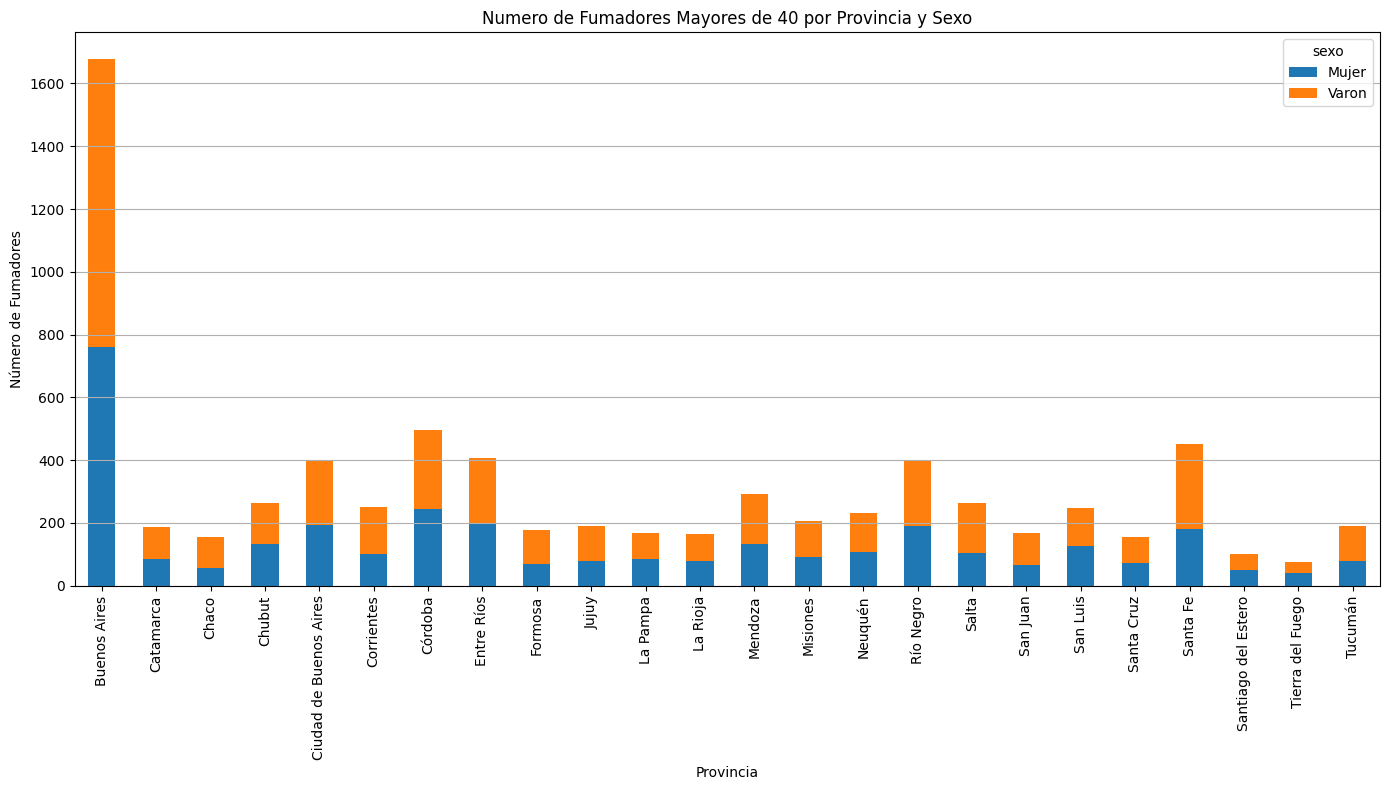

In [ ]:
# Graficamos
pivot_tabla.plot(kind='bar', figsize=(14, 8), stacked=True)
plt.title('Numero de Fumadores Mayores de 40 por Provincia y Sexo')
plt.xlabel('Provincia')
plt.ylabel('Número de Fumadores')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

En la tabla superior 'Numero de Fumadores Mayores de 40 por Provincia y Sexo', puede observarse que en la mayoria de las provincias los fumadores tienden a ser mayormente hombres. Para poder comparar en que provincia es mayor la proporcion de fumadores, debo tener en cuenta la cantidad de encuestados no fumadores.